In [3]:
# @title Copyright & License (click to expand)
# MIT License

# Copyright (c)
# Jiale Shi and Dandan Tang

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Earth Mover's Distance (EMD)-based Kernel Gaussian Processes Classification from Scratch for Mixture Properties Predictions

## References

\[1\] Martin Krasser. [Gaussian Processes from Scratch](https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes.ipynb).

\[2\] Kevin P. Murphy. [Machine Learning, A Probabilistic Perspective](https://mitpress.mit.edu/books/machine-learning-0), Chapters 4, 14 and 15.  

\[3\] Christopher M. Bishop. [Pattern Recognition and Machine Learning](http://www.springer.com/de/book/9780387310732), Chapter 6.  

\[4\] Carl Edward Rasmussen and Christopher K. I. Williams. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import time

from scipy.optimize import minimize
from scipy.stats import bernoulli
from scipy.special import expit as sigmoid

from sklearn.datasets import make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

import shutil
from numpy.linalg import inv
from numpy.linalg import cholesky, det
from scipy.linalg import solve_triangular
from scipy.optimize import minimize

import ot
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem.rdFingerprintGenerator import GetRDKitFPGenerator

# EMD Function

$ EMD (P,Q)= \min_{F}\sum_{i=1}^{m}\sum_{j=1}^{n}f_{i,j}d_{i,j}$

$ {\rm subject\ to\ } f_{i,j} \geq 0, {\rm\ for\ any\ } \ 1 \leq i \leq m, 1 \leq j \leq n $

$     \sum_{j=1}^{n}f_{i,j} =w_{pi}, {\rm for\ any} \ 1 \leq i \leq m $

$     \sum_{i=1}^{m}f_{i,j} =w_{qj}, {\rm for\ any} \ 1 \leq j \leq n $

$     \sum_{i=1}^{m}\sum_{j=1}^{n}f_{i,j} = \sum_{i}^{m} w_{pi} = \sum_{j}^{n} w_{qj} = 1 $ 


Molecular mixture/ensemble $P = \{(p_1,w_{p_1}) ,(p_2,w_{p_2}),...,(p_i,w_{p_i}),...,(p_m,w_{p_m})\}$ has $m$ molecular components, where $p_i$ is a molecular component such  and $w_{p_i}>0$ is the weight, related to the average probability (or frequency, $z$) of the molecular component being present in the mixture/ensemble. Similarly, the second mixture/ensemble $Q = {(q_1,w_{q_1}),(q_2,w_{q_2}),...,(q_j,w_{q_j}),...,(q_n,w_{q_n})}$ has $n$ molecular components.  The sums of the weights for $P$ and $Q$ are both normalized and equal to one.
The distance $d_{i,j}$ is calculated by the converting the pairwise similarity score $s_{i,j}$ between $p_{i}$ and $q_{j}$, where $d_{i,j} = 1 - s_{i,j}$.
Transport flow $f_{i,j}$ represents the amount of weight at $p_i$ which is transported to $q_j$. 

The EMD linear optimization code for molecule mixtures refers to [Polymer-Graph-Similarity](https://github.com/olsenlabmit/Polymer-Graph-Similarity/tree/main)


In [22]:
def EMD_Calculation_pot(
    query_smiles_list=None,
    query_smiles_weight_list=None,
    target_smiles_list=None,
    target_smiles_weight_list=None,
    embedding_function="MorganFingerprint",
    similarity_score_function="Tanimoto",
    radius = 2,
    num_bits = 2048,
):
    # obtain the length of query smiles list and target smiles list
    query_smiles_list_length = len(query_smiles_list)

    target_smiles_list_length = len(target_smiles_list)

    query_smiles_weight_list = list(np.ones([query_smiles_list_length]))

    target_smiles_weight_list = list(np.ones([target_smiles_list_length]))


    # transfer SMILES to fingerprints
    if embedding_function == "RDKFingerprint":

        fpgen = GetRDKitFPGenerator(fpSize=num_bits)

        #fps = [fpgen.GetFingerprint(x) for x in ms]

        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [fpgen.GetFingerprint(x)for x in query_mol_list]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [fpgen.GetFingerprint(x) for x in target_mol_list]

    elif embedding_function == "MorganFingerprint":
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [
            AllChem.GetMorganFingerprintAsBitVect(x, radius, nBits=num_bits)
            for x in query_mol_list
        ]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [
            AllChem.GetMorganFingerprintAsBitVect(x, radius, nBits=num_bits)
            for x in target_mol_list
        ]

    elif embedding_function == "MACCSkeys":
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [MACCSkeys.GenMACCSKeys(x) for x in query_mol_list]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [MACCSkeys.GenMACCSKeys(x) for x in target_mol_list]

    else:
        print(
            embedding_function
            + " is not included in the current vision."
            + " Please choose an available embedding function:"
        )
        print("MorganFingerprint, RDKFingerprint, MACCSkeys.")
        return False

    # define the required three sets
    C = np.zeros([query_smiles_list_length,target_smiles_list_length ])

    # use similarity function to calculate d_ij
    if similarity_score_function == "Tanimoto":
        for i in range(0, query_smiles_list_length):
            for j in range(0, target_smiles_list_length):
                C[i,j] = 1 - DataStructs.FingerprintSimilarity(
                    query_fingerprint_list[i], target_fingerprint_list[j],
                    metric=DataStructs.TanimotoSimilarity

                )

    elif similarity_score_function == "Dice":
        for i in range(0, query_smiles_list_length):
            for j in range(0, target_smiles_list_length):
                C[i,j] = 1 - DataStructs.FingerprintSimilarity(
                    query_fingerprint_list[i], target_fingerprint_list[j],
                    metric=DataStructs.DiceSimilarity
                )

    elif similarity_score_function == "Cosine":
        for i in range(0, query_smiles_list_length):
            for j in range(0, target_smiles_list_length):
                C[i,j] = 1 - DataStructs.FingerprintSimilarity(
                    query_fingerprint_list[i], target_fingerprint_list[j],
                    metric=DataStructs.CosineSimilarity
                )

    else:
        print(
            similarity_score_function
            + " is not included in the current vision."
            + " Please choose an available similarity function:"
        )
        print("Tanimoto, Dice, or Cosine")
        return

    #print(C)
    query_smiles_weight_array = np.array(query_smiles_weight_list)/sum(np.array(query_smiles_weight_list))
    target_smiles_weight_array = np.array(target_smiles_weight_list)/sum(np.array(target_smiles_weight_list))
    #print(query_smiles_weight_array, target_smiles_weight_array)
    ot_emd = ot.emd(query_smiles_weight_array, target_smiles_weight_array, C)
    #print(ot_emd)

    W = np.sum(ot_emd * C)
    #print(W)
    return W

Here, we will use the squared exponential kernel, also known as Gaussian kernel or RBF kernel.
Here is the default RBF which uses Euclidean distance.
$$
\kappa(\mathbf{x}_P,\mathbf{x}_Q) = \sigma_f^2 \exp\left(-\frac{d(\mathbf{x}_P - \mathbf{x}_Q)^2}{2l^2}\right)
$$

$d(\mathbf{x}_P - \mathbf{x}_Q)^2$ is the Euclidean distance between $\mathbf{x}_P$ and $\mathbf{x}_Q$. The length parameter $l$ controls the smoothness of the function and $\sigma_f$ the vertical variation. For simplicity, we use the same length parameter $l$ for all input dimensions (isotropic kernel).

However, for mixtures, usually it is hard to get the good embedding vector $\mathbf{x}_P$ and $\mathbf{x}_Q$. EMD provides a way to calculate the distance between mixture P and Q from the individual component distance without the needs to get the embedding vector $\mathbf{x}_P$ and $\mathbf{x}_Q$.

$$
\kappa(\mathbf{P},\mathbf{Q}) = \sigma_f^2 \exp\left(-\frac{EMD(\mathbf{P}, \mathbf{Q})^2}{2l^2}\right)
$$

In [91]:
def kernel(X1, X2, theta):
    """
    Isotropic squared exponential kernel.

    Args:
        X1: Array of m points (m x dict).
        X2: Array of n points (n x dict).
        theta: Kernel parameters

    Returns:
        (m x n) matrix
    """
    m = X1.shape[0]
    n = X2.shape[0]
    
    sqdist = np.zeros([m,n])
    start_time = time.time()

    for i in np.arange(0,m):
        for j in np.arange(0,n):
            xi = X1[i].item() # dict such as {"COC":0.5, "CC": 0.5}
            xj = X2[j].item() # dict such as {"CCCO": 0.2, "CCS": 0.4, 'CO': 0.4}
            #print(x1, x2)
            emd = EMD_Calculation_pot(query_smiles_list=xi["components"],
                                              query_smiles_weight_list=xi["weights"],
                                              target_smiles_list=xj["components"],
                                              target_smiles_weight_list=xj["weights"],
                                              embedding_function="MorganFingerprint",
                                              similarity_score_function="Tanimoto",
                                              radius = 5,
                                              num_bits = 2048)
            sqdist[i,j] = emd**2
            #print(i,j, sqdist[i,j])
    end_time = time.time()
    print(sqdist.shape, "time_cost:", end_time- start_time, "seconds")
    
    return theta[1] ** 2 * np.exp(-0.5 / theta[0] ** 2 * sqdist)


In [82]:
def K_(X, theta, diag_only=False, nu=1e-5):
    """Helper to apply kernel function."""
    if diag_only:
        # Specific solution for isotropic 
        # squared exponential kernel.
        return theta[1] ** 2 + nu
    else:
        return kernel(X, X, theta) + nu * np.eye(X.shape[0])

def W_(a):
    """Helper to compute matrix W."""
    r = sigmoid(a) * (1 - sigmoid(a))
    return np.diag(r.ravel())


In [83]:
def posterior_mode(X, t, K_a, max_iter=10, tol=1e-9):
    """
    Computes the mode of posterior p(a|t).
    """
    a_h = np.zeros_like(t)
    I = np.eye(X.shape[0])

    for i in range(max_iter):
        W = W_(a_h)
        Q_inv = np.linalg.inv(I + W @ K_a)
        a_h_new = (K_a @ Q_inv).dot(t - sigmoid(a_h) + W.dot(a_h))
        a_h_diff = np.abs(a_h_new - a_h)
        a_h = a_h_new

        if not np.any(a_h_diff > tol):
            break

    return a_h


In [84]:
def nll_fn(X, t):
    """
    Returns the negative log-likelihood function for data X, t.
    """
    
    t = t.ravel()

    def nll(theta):
        K_a = K_(X, theta)
        K_a_inv = np.linalg.inv(K_a)

        # posterior mode depends on theta (via K)
        a_h = posterior_mode(X, t, K_a).ravel()
        W = W_(a_h)

        ll = - 0.5 * a_h.T.dot(K_a_inv).dot(a_h) \
             - 0.5 * np.linalg.slogdet(K_a)[1] \
             - 0.5 * np.linalg.slogdet(W + K_a_inv)[1] \
             + t.dot(a_h) - np.sum(np.log(1.0 + np.exp(a_h)))

        return -ll

    return nll


In [ ]:
file_path = 'reaction_dh.json'

# Open the JSON file for reading
with open(file_path, 'r') as file:
    # Load the file's content as a Python dictionary
    data = json.load(file)
    
X_small = []
y_small = []

X_large = []
y_large = []

for i in range(0, len(data["mixture_list"])):
    
    components = data["mixture_list"][i]["components"]
    weights = data["mixture_list"][i]["weights"]
    dict_i = {}
    dict_i['components'] = components
    dict_i["weights"]= weights
    if data["mixture_list"][i]['figure_of_merit'] >= 90:
        
        X_large.append(dict_i)
        y_large.append(1)
        
    elif data["mixture_list"][i]['figure_of_merit'] <= 10:
        
        X_small.append(dict_i)
        y_small.append(0)        
        
    if None in components:
        print("error")

large_index = range(0, len(y_large))
sample_large_index = random.sample(large_index, len(y_small))
X_large_sample =  [X_large[i] for i in sample_large_index]
y_large_sample =  [y_large[i] for i in sample_large_index]

X = X_small + X_large_sample
y = y_small + y_large_sample

X = np.array(X).reshape(-1,1)
y = np.array(y).reshape(-1,1)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, test_size = 0.2, random_state = 2019)

In [ ]:
res = minimize(nll_fn(X_train, y_train), [1, 1],
               bounds=((1e-3, None), (1e-3, None)),
               method='L-BFGS-B')

theta = res.x

print(f'Optimized theta = [{theta[0]:.3f}, {theta[1]:.3f}], negative log likelihood = {res.fun:.3f}')

In [96]:
def predict_a(X_test, X, t, theta):
    """
    Computes the mean and variance of logits at points X_test
    given training data X, t and kernel parameters theta.
    """
    K_a = K_(X, theta)
    K_s = kernel(X, X_test, theta)
    a_h = posterior_mode(X, t, K_a)

    W_inv = np.linalg.inv(W_(a_h))
    R_inv = np.linalg.inv(W_inv + K_a)

    a_test_mu = K_s.T.dot(t - sigmoid(a_h))
    # Compute variances only (= diagonal) instead of full covariance matrix
    a_test_var = K_(X_test, theta, diag_only=True) - np.sum((R_inv @ K_s) * K_s, axis=0).reshape(-1, 1)

    return a_test_mu, a_test_var


def predict_pt(X_test, X, t, theta):
    """
    Computes the probability of t=1 at points X_test
    given training data X, t and kernel parameters theta.
    """
    a_mu, a_var = predict_a(X_test, X, t, theta)
    kappa = 1.0 / np.sqrt(1.0 + np.pi * a_var / 8)
    return sigmoid(kappa * a_mu)


In [106]:
pt_test = predict_pt(X_test, X_train, y_train, theta)
prediction = []
for i in range(0, len(pt_test)):
    if pt_test[i] <0.5:
        prediction.append(0)
    else:
        prediction.append(1)
prediction = np.array(prediction).reshape(-1,1)

(401, 401) time_cost: 106.5637559890747 seconds
(401, 101) time_cost: 26.354514837265015 seconds


In [105]:
print("accuracy:", sum(prediction == y_test)/len(y_test))

accuracy: [0.99009901]


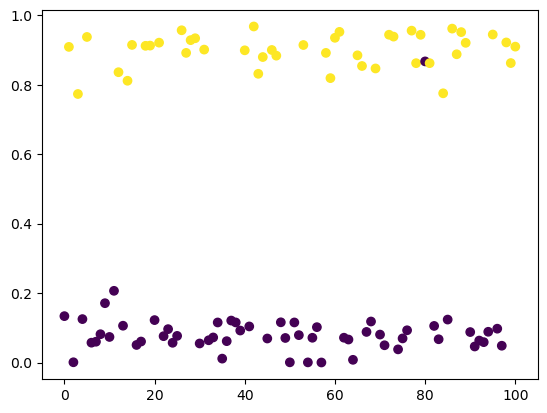

In [101]:
plt.scatter(np.arange(0,prediction.shape[0]), pt_test, c = y_test.reshape(1,-1)[0].tolist())